# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored in 2016 and has seen impressive results in generating new images; you can read the [original paper, here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

<img src='assets/svhn_dcgan.png' width=80% />

So, our goal is to create a DCGAN that can generate new, realistic-looking images of house numbers. We'll go through the following steps to do this:
* Load in and pre-process the house numbers dataset
* Define discriminator and generator networks
* Train these adversarial networks
* Visualize the loss over time and some sample, generated images

#### Deeper Convolutional Networks

Since this dataset is more complex than our MNIST data, we'll need a deeper network to accurately identify patterns in these images and be able to generate new ones. Specifically, we'll use a series of convolutional or transpose convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get these convolutional networks to train. 

Besides these changes in network structure, training the discriminator and generator networks should be the same as before. That is, the discriminator will alternate training on real and fake (generated) images, and the generator will aim to trick the discriminator into thinking that its generated images are real!

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl

%matplotlib inline

## Getting the data

Here you can download the SVHN dataset. It's a dataset built-in to the PyTorch datasets library. We can load in training data, transform it into Tensor datatypes, then create dataloaders to batch our data into a desired size.

In [2]:
import torch
from torchvision import datasets
from torchvision import transforms

# Tensor transform
transform = transforms.ToTensor()

# SVHN training datasets
svhn_train = datasets.SVHN(root='data/', split='train', download=True, transform=transform)

batch_size = 128
num_workers = 0

# build DataLoaders for SVHN dataset
train_loader = torch.utils.data.DataLoader(dataset=svhn_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_workers)


Using downloaded and verified file: data/train_32x32.mat


### Visualize the Data

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real, training images that we'll pass to the discriminator. Notice that each image has _one_ associated, numerical label.

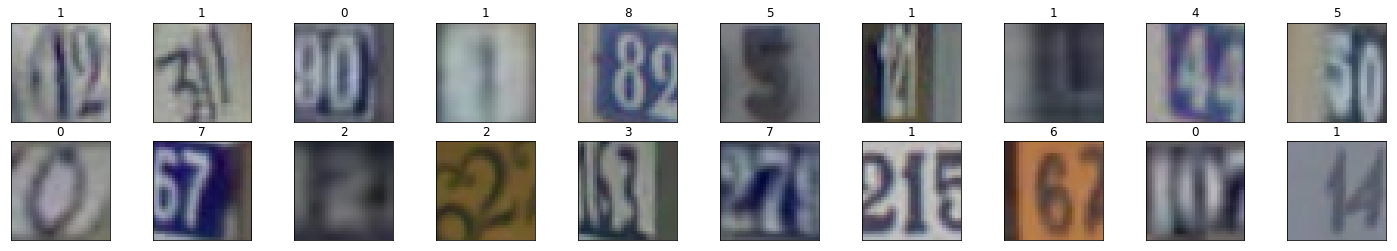

In [3]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[idx], (1, 2, 0)))
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### Pre-processing: scaling from -1 to 1

We need to do a bit of pre-processing; we know that the output of our `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [10]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(1.00000e-02 *
       7.8431)
Max:  tensor(0.7725)


In [11]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    min, max = feature_range
    # scale to feature_range and return scaled x
    x = x*(max - min) + min
    
    return x


In [13]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-0.8431)
Scaled max:  tensor(0.5451)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Here you'll build the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. 
* The inputs to the discriminator are 32x32x3 tensor images
* You'll want a few convolutional, hidden layers
* Then a fully connected layer for the output; as before, we want a sigmoid output, but we'll add that in the loss function, [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss), later

<img src='assets/conv_discriminator.png' width=80%/>

For the depths of the convolutional layers I suggest starting with 32 filters in the first layer, then double that depth as you add layers (to 64, 128, etc.). Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpooling layers.

You'll also want to use batch normalization with [nn.BatchNorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d) on each layer **except** the first convolutional layer and final, linear output layer. 

#### Helper `conv` function 

In general, each layer should look something like convolution > batch norm > leaky ReLU, and so we'll define a function to put these layers together. This function will create a sequential series of a convolutional + an optional batch norm layer. We'll create these using PyTorch's [Sequential container](https://pytorch.org/docs/stable/nn.html#sequential), which takes in a list of layers and creates layers according to the order that they are passed in to the Sequential constructor.

Note: It is also suggested that you use a **kernel_size of 4** and a **stride of 2** for strided convolutions.

In [14]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)


In [15]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        super(Discriminator, self).__init__()
        
        self.conv_dim = conv_dim
        # complete init function
        self.conv1 = conv(3,conv_dim,kernel_size=4,stride=2,padding=1,batch_norm=False)
        self.conv2 = conv(conv_dim,conv_dim*2,kernel_size=4,stride=2,padding=1,batch_norm=True)
        self.conv3 = conv(conv_dim*2,conv_dim*2*2,kernel_size=4,stride=2,padding=1,batch_norm=True)
        self.fc1 = nn.Linear(conv_dim*4*4*4,1)

    def forward(self, x):
        # complete forward function
        x = F.leaky_relu(self.conv1(x),0.02)
        x = F.leaky_relu(self.conv2(x),0.02)
        x = F.leaky_relu(self.conv3(x),0.02)
        x = x.view(-1,self.conv_dim*4*4*4)
        x = self.fc1(x)
            
        
        return x
    

## Generator

Next, you'll build the generator network. The input will be our noise vector `z`, as before. And, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

<img src='assets/conv_generator.png' width=80% />

What's new here is we'll use transpose convolutional layers to create our new images. 
* The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x512. 
* Then, we use batch normalization and a leaky ReLU activation. 
* Next is a series of [transpose convolutional layers](https://pytorch.org/docs/stable/nn.html#convtranspose2d), where you typically halve the depth and double the width and height of the previous layer. 
* And, we'll apply batch normalization and ReLU to all but the last of these hidden layers. Where we will just apply a `tanh` activation.

#### Helper `deconv` function

For each of these layers, the general scheme is transpose convolution > batch norm > ReLU, and so we'll define a function to put these layers together. This function will create a sequential series of a transpose convolutional + an optional batch norm layer. We'll create these using PyTorch's Sequential container, which takes in a list of layers and creates layers according to the order that they are passed in to the Sequential constructor.

Note: It is also suggested that you use a **kernel_size of 4** and a **stride of 2** for transpose convolutions.

In [16]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    ## TODO: Complete this function
    ## create a sequence of transpose + optional batch norm layers
    layers = []
    conv_layer = nn.ConvTranspose2d(in_channels, out_channels,kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)


In [25]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=32):
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.fc1 = nn.Linear(z_size,conv_dim*4*4*4)
        
        self.Tconv1 = deconv(conv_dim*4,conv_dim*2,kernel_size=4,stride=2,padding=1,batch_norm = True)
        self.Tconv2 = deconv(conv_dim*2,conv_dim,kernel_size=4,stride=2,padding=1,batch_norm = True)
        self.Tconv3 = deconv(conv_dim,3,kernel_size=4,stride=2,padding=1,batch_norm = False)
        
        

    def forward(self, x):
        # complete forward function
        x = self.fc1(x)
        x = x.view(-1,conv_dim*4,4,4)
        
        x = F.relu(self.Tconv1(x))
        x = F.relu(self.Tconv2(x))
        x = F.tanh(self.Tconv3(x))
        
        
        return x
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [27]:
# define hyperparams
conv_dim = 32
z_size = 100

# define discriminator and generator
D = Discriminator(conv_dim)
G = Generator(z_size=z_size, conv_dim=conv_dim)

print(D)
print()
print(G)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc1): Linear(in_features=100, out_features=2048, bias=True)
  (Tconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Tconv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

### Training on GPU

Check if you can train on GPU. If you can, set this as a variable and move your models to GPU. 
> Later, we'll also move any inputs our models and loss functions see (real_images, z, and ground truth labels) to GPU as well.

In [28]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    # move models to GPU
    G.cuda()
    D.cuda()
    print('GPU available for training. Models moved to GPU')
else:
    print('Training on CPU.')
    

GPU available for training. Models moved to GPU


---
## Discriminator and Generator Losses

Now we need to calculate the losses. And this will be exactly the same as before.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.

The losses will by binary cross entropy loss with logits, which we can get with [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss). This combines a `sigmoid` activation function **and** and binary cross entropy loss in one function.

For the real images, we want `D(real_images) = 1`. That is, we want the discriminator to classify the the real images with a label = 1, indicating that these are real. The discriminator loss for the fake data is similar. We want `D(fake_images) = 0`, where the fake images are the _generator output_, `fake_images = G(z)`. 

### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get `D(fake_images) = 1`. In this case, the labels are **flipped** to represent that the generator is trying to fool the discriminator into thinking that the images it generates (fakes) are real!

In [29]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

Not much new here, but notice how I am using a small learning rate and custom parameters for the Adam optimizers, This is based on some research into DCGAN model convergence.

### Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

In [30]:
import torch.optim as optim

# params
lr = 0.0002
beta1= 0.5
beta2=0.999

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. We'll use our functions `real_loss` and `fake_loss` to help us calculate the discriminator losses in all of the following cases.

### Discriminator training
1. Compute the discriminator loss on real, training images        
2. Generate fake images
3. Compute the discriminator loss on fake, generated images     
4. Add up real and fake loss
5. Perform backpropagation + an optimization step to update the discriminator's weights

### Generator training
1. Generate fake images
2. Compute the discriminator loss on fake images, using **flipped** labels!
3. Perform backpropagation + an optimization step to update the generator's weights

#### Saving Samples

As we train, we'll also print out some loss statistics and save some generated "fake" samples.

**Evaluation mode**

Notice that, when we call our generator to create the samples to display, we set our model to evaluation mode: `G.eval()`. That's so the batch normalization layers will use the population statistics rather than the batch statistics (as they do during training), *and* so dropout layers will operate in eval() mode; not turning off any nodes for generating samples.

In [31]:
import pickle as pkl

# training hyperparams
num_epochs = 50

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 300

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        # important rescaling step
        real_images = scale(real_images)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        if train_on_gpu:
            real_images = real_images.cuda()
        
        D_real = D(real_images)
        d_real_loss = real_loss(D_real)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        # move x to GPU, if available
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images            
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            losses.append((d_loss.item(), g_loss.item()))
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##    
    # generate and save sample, fake images
    G.eval() # for generating samples
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to training mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/   50] | d_loss: 1.3775 | g_loss: 0.8666
Epoch [    1/   50] | d_loss: 0.6652 | g_loss: 1.5363
Epoch [    2/   50] | d_loss: 0.8921 | g_loss: 1.5513
Epoch [    2/   50] | d_loss: 0.8648 | g_loss: 1.4700
Epoch [    3/   50] | d_loss: 1.4785 | g_loss: 0.8662
Epoch [    3/   50] | d_loss: 0.8301 | g_loss: 1.4035
Epoch [    4/   50] | d_loss: 0.7829 | g_loss: 2.3376
Epoch [    4/   50] | d_loss: 0.7343 | g_loss: 1.9114
Epoch [    5/   50] | d_loss: 0.5747 | g_loss: 2.0234
Epoch [    5/   50] | d_loss: 0.6168 | g_loss: 1.3556
Epoch [    6/   50] | d_loss: 0.4937 | g_loss: 1.3885
Epoch [    6/   50] | d_loss: 0.6006 | g_loss: 2.2009
Epoch [    7/   50] | d_loss: 0.4130 | g_loss: 2.5385
Epoch [    7/   50] | d_loss: 0.3658 | g_loss: 2.5637
Epoch [    8/   50] | d_loss: 0.5296 | g_loss: 2.6830
Epoch [    8/   50] | d_loss: 0.5648 | g_loss: 2.1423
Epoch [    9/   50] | d_loss: 0.4279 | g_loss: 2.4924
Epoch [    9/   50] | d_loss: 0.3275 | g_loss: 1.6329
Epoch [   10/   50] | d_loss

## Training loss

Here we'll plot the training losses for the generator and discriminator, recorded after each epoch.

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

Here we can view samples of images from the generator. We'll look at the images we saved during training.

In [ ]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [ ]:
_ = view_samples(-1, samples)